## Disaster detection from tweets
This was a project from a Kaggle tutorial on Deep learning for NLP. The aim of the project is to predict whether a tweet is about an actual disaster or not based on the content of the tweet

[Tutorial link](https://www.kaggle.com/philculliton/nlp-getting-started-tutorial)

[LSA tutorial](http://mccormickml.com/2016/03/25/lsa-for-text-classification-tutorial/)

[Count Vectorizer, TF-IDF vectorizer](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import sklearn
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [17]:
''' Read data and look at examples of each type
'''
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print('Non-disaster tweet: ', end='')
print(train_df[train_df["target"] == 0]["text"].values[1])

print('Ddisaster tweet: ', end='')
print(train_df[train_df["target"] == 1]["text"].values[1])

Non-disaster tweet: I love fruits
Ddisaster tweet: Forest fire near La Ronge Sask. Canada


### Get statistics of the dataset
* How many training example of each category?

In [6]:
disaster = (train_df['target']==1).sum();
no_disaster = (train_df['target']==0).sum();
total = disaster + no_disaster

print('===== Training dataset ======')
print(f'Disaster tweets = {disaster}, no disaster tweets = {no_disaster} out of {total} tweets')
print(f'Random assignment accuracy: {np.max((disaster, no_disaster))/total*100:0.2f}')

y_true = train_df['target'];
y_pred = np.ones_like(y_true);
print('\nIf we just predicted every tweet as being disastrous, the f1-score is:',end=" ")
print(f'{sklearn.metrics.f1_score(y_true,y_pred)*100:0.2f}')

print('So we should do better than this....')

===== Training dataset ======
Disaster tweets = 3271, no disaster tweets = 4342 out of 7613 tweets
Random assignment accuracy: 57.03

If we just predicted every tweet as being disastrous, the f1-score is: 60.11
So we should do better than this....


### Building vectors
Let's first make a basic classifier where we use the words contained in the tweet to determine if the tweet is about a real disaster or not

Below I report f1-scores for the following methods

* Using scikit-learn's CountVectorizer to count the number of occurrences of every word and then classifying using a Ridge Regression
* Using TF-IDF Vectorizer
* Using a Neural Network


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

#### Make dicts of all classifiers and features

In [17]:
''' Dict of classifiers
'''
clf = linear_model.RidgeClassifier()
# clf = linear_model.Lasso(alpha=1e-6); 
clf_knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
clf_log = LogisticRegression(penalty='l2')
clf_svm = svm.SVC(gamma=0.1, C=2000);
random_forest = RandomForestClassifier(n_estimators=100,min_samples_leaf=3, max_features=50)
boosted_tree = AdaBoostClassifier(n_estimators=100)
elastic_net = LogisticRegression(penalty='elasticnet',solver = 'saga', l1_ratio = 0.5)

clf_dict ={'Elastic Net': elastic_net,'Ridge':clf, 'KNN':clf_knn, 'Log Reg':clf_log, 'SVM': clf_svm, 
           'Random Forest': random_forest,'Boosted tree': boosted_tree};

In [9]:
''' Dict of features
'''
# Count vectorizer
count_vectorizer = feature_extraction.text.CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train_df["text"])

# TF-IDF
vectorizer = feature_extraction.text.TfidfVectorizer()
train_vectors_tfidf = vectorizer.fit_transform(train_df["text"])

# LSA
svd = TruncatedSVD(100)
train_vectors_tfidf_svd = svd.fit_transform(train_vectors_tfidf)

feat = {'Count Vectorizer':train_vectors, 
       'TF IDF': train_vectors_tfidf,
       'LSA': train_vectors_tfidf_svd}

Hyper-parameter search for SVM. Skip this for calculating scores

In [146]:
ss = np.zeros((10,12))
for ig, g in enumerate(np.logspace(-9,9,10)):
    for iC, C in enumerate(np.logspace(-2, 10,12)):
        scores = model_selection.cross_val_score(svm.SVC(C=C, gamma=g), train_vectors, 
                                                 train_df["target"].astype(int),cv=3, scoring='f1')
        ss[ig,iC] = scores.mean();
        
plt.imshow(ss);
plt.xticks(np.arange(0,12), np.logspace(-2, 10,12),rotation=60); 
plt.yticks(np.arange(0,10), np.logspace(-9,9,10));
plt.show()

Hyper parameter search for Random Forest. Skip this for calculating final scores

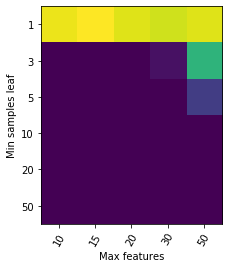

In [16]:
min_samples_leaf = np.array([1,3,5,10,20,50]);
max_features = np.array([10,15,20,30,50]);

score_random_forest = np.zeros((len(min_samples_leaf), len(max_features)))
for isample, ns in enumerate(min_samples_leaf):
    for ifeature, nf in enumerate(max_features):
        scores = model_selection.cross_val_score(RandomForestClassifier(n_estimators=100,min_samples_leaf=ns, max_features=nf),
                                                train_vectors, train_df['target'].astype(int), cv=3, scoring='f1');
        
        score_random_forest[isample, ifeature] = scores.mean();
plt.imshow(score_random_forest);
plt.xticks(np.arange(0,len(max_features)), max_features, rotation=60); plt.xlabel('Max features');
plt.yticks(np.arange(0,len(min_samples_leaf)), min_samples_leaf); plt.ylabel('Min samples leaf');
plt.show()

##### Let's calculate f-1 scores for each classifier with each feature set

In [18]:
df_scores = pd.DataFrame();
for (key, item) in clf_dict.items():
    for (key_f, item_f) in feat.items():
        scores = model_selection.cross_val_score(item, item_f, 
                                                 train_df["target"].astype(int),cv=3, scoring='f1')
        df_scores = df_scores.append({'Features':key_f,'Classifier':key,
                                  'f1':np.mean(scores)},ignore_index=True)

##### 1) Count Vectorizer

This is not much better than random assignment accuracy of 57%

##### 2) TF-IDF Vectorizer + Ridge Regression
Count Vectorizer weighs each word equally, but there might be some words that are present often but do not provide much information about the content, e.g., 'a', 'the' etc. In order to account for that, we can use a different vectorizer called TF-IDF, where each terms's frequency $(tf)$ is multiplied by $idf$ or inverse-document frequency. If a word occurs in a lot of documents (here, tweets), then it's idf is low and vice-versa

In short, the rarer a word, the higher is its TF-IDF score

##### 3) Latent Semantic Analysis (LSA)
LSA is basically a version of TF-IDF with reduced dimensionality via SVD decomposition. It preserves the high variance features and removes the high frequency features.

Interestingly, the performance is lower with LSA suggesting that the high frequency/low variance terms are important in classification

In [19]:
df_scores

,Classifier,Features,f1
0,Elastic Net,Count Vectorizer,0.628939
1,Elastic Net,TF IDF,0.593253
2,Elastic Net,LSA,0.627579
3,Ridge,Count Vectorizer,0.608069
4,Ridge,TF IDF,0.643725
5,Ridge,LSA,0.634295
6,KNN,Count Vectorizer,0.159711
7,KNN,TF IDF,0.612973
8,KNN,LSA,0.522100
9,Log Reg,Count Vectorizer,0.646067


In [30]:
clf_svm.fit(train_vectors_tfidf_svd, train_df['target'].astype(int))

vectorizer_test = feature_extraction.text.TfidfVectorizer()
test_vectors_tfidf = vectorizer.fit_transform(test_df["text"])
svd = TruncatedSVD(100)
test_vectors_tfidf_svd = svd.fit_transform(test_vectors_tfidf)

y_pred = clf_svm.predict(test_vectors_tfidf_svd);

df_test = pd.DataFrame(test_df['id'])
df_test['target'] = y_pred;
df_test.to_csv('Predictions.csv',index=False)

Next, I try to use an (bi)LSTM for classification. These worked very well for movie genre classification in the IMDB dataset in my other notebook

In [41]:
from torchtext import data, datasets
import nltk
import torch
import random
from torch import nn
from tqdm import tqdm

In [53]:
sentence_length=50
TEXT = data.Field(sequential=True,
                    tokenize=nltk.word_tokenize,
                    lower=True,
                    include_lengths=True,
                    batch_first=True,
                    fix_length=sentence_length)
LABEL = data.LabelField(dtype=torch.float)


In [57]:
fields = {'text': ('t', TEXT), 'target': ('l', LABEL)}
train_data = data.TabularDataset.splits(
                            path = '',
                            train = 'train.csv',
                            format = 'csv',
                            fields = fields
)
train_data = train_data[0]

In [58]:
seed=2021; batch_size=32
TEXT.build_vocab(train_data)
train_data, valid_data = train_data.split(split_ratio=0.7,
                                            random_state=random.seed(seed))
train_iter, valid_iter = data.BucketIterator.splits((train_data, valid_data),
                                                                  batch_size=batch_size, sort_key=lambda x: len(x.text),
                                                                  repeat=False, shuffle=True)
vocab_size = len(TEXT.vocab)


In [65]:
train_data[0]

In [37]:
def train_from_tutorial(model, device, train_iter, valid_iter, epochs, learning_rate):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  for epoch in tqdm(range(epochs),position=0,leave=True):
    #train
    model.train()
    running_loss = 0.
    correct, total = 0, 0
    steps = 0

    for idx, batch in enumerate(train_iter):
      text = batch.text[0]
      # print(type(text), text.shape)
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      # add micro for coding training loop
      optimizer.zero_grad()
      output = model(text)

      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      steps += 1
      running_loss += loss.item()

      # get accuracy
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    train_loss.append(running_loss/len(train_iter))
    train_acc.append(correct/total)

#     print(f'Epoch: {epoch + 1}, '
#           f'Training Loss: {running_loss/len(train_iter):.4f}, '
#           f'Training Accuracy: {100*correct/total: .2f}%')

    # evaluate on validation data
    model.eval()
    running_loss = 0.
    correct, total = 0, 0

    with torch.no_grad():
      for idx, batch in enumerate(valid_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(text)

        loss = criterion(output, target)
        running_loss += loss.item()

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    validation_loss.append(running_loss/len(valid_iter))
    validation_acc.append(correct/total)

#     print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, '
#            f'Validation Accuracy: {100*correct/total: .2f}%')

  return train_loss, train_acc, validation_loss, validation_acc



In [44]:
class LSTM(nn.Module):
    def __init__(self,layers,output_size,hidden_size,vocab_size,embed_size):
        super(LSTM,self).__init__();
        self.n_layers=layers;
        self.output_size=output_size;
        self.hidden_size=hidden_size;
        
        self.word_embeddings = nn.Embedding(vocab_size,embed_size);
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=self.n_layers)
        self.fc = nn.Linear(self.n_layers*self.hidden_size, self.output_size);
        
    def forward(self,input_sentences):
        inp = self.word_embeddings(input_sentences).permute(1,0,2);
        hidden = (torch.randn(self.n_layers, inp.shape[1], self.hidden_size),
        torch.randn(self.n_layers, inp.shape[1], self.hidden_size))
        
        inp = self.dropout(inp);
        output, hidden = self.lstm(inp, hidden);
        
        h_n = hidden[0].permute(1, 0, 2)
        h_n = h_n.contiguous().view(h_n.shape[0], -1)

        logits = self.fc(h_n)
        
        return logits
    
sampleLSTM = LSTM(2, 2, 50, vocab_size, 100)
sampleLSTM

bilstm_train_loss, bilstm_train_acc, bilstm_validation_loss, bilstm_validation_acc = train_from_tutorial(sampleLSTM,
                                                                                                         'cpu',
                                                                    train_iter,
                                                                    valid_iter,
                                                                    30,0.0003)


  0%|          | 0/30 [00:00<?, ?it/s]


AttributeError: 'LabelField' object has no attribute 'vocab'

In [52]:
train_iter.text

AttributeError: 'BucketIterator' object has no attribute 'text'

#### 4) Simple Neural Network

In [136]:

def create_model():
    model = Sequential()
    model.add(Dense(1000, input_dim=21637, activation='relu'))
    model.add(Dense(20, input_dim=1000, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
idx_sort_tgt = np.argsort(train_df['target'])
sort_values = train_df['target'][idx_sort_tgt].values;
sort_train = train_vectors[idx_sort_tgt,:].toarray()

scores = model_selection.cross_val_score(model, sort_train, sort_values, cv=3,scoring="f1")
scores

array([0.        , 0.42466887, 0.29617193])

In [137]:
df_scores = df_scores.append({'Classifier':'MLP','Features':'Count Vectorizer','f1':np.mean(scores)},ignore_index=True)
